In [11]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.optimizers import SGD, RMSprop
from keras.applications.vgg16 import VGG16, preprocess_input


# from google.colab import drive
# drive.mount("/content/gdrive")

In [12]:
import keras
print(keras.__version__)

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

2.2.4
['/job:localhost/replica:0/task:0/device:GPU:0']


In [13]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Balanced_Training_Input/"
# path_to_description = drive_base_path + "dataset/ISIC2018_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv"

In [14]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

In [15]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
train_generator = datagen.flow_from_directory(
                    directory=path_to_images,
                    target_size=(224, 224),
                    batch_size=32,
                    classes=classes,
                    shuffle=True)

Found 16639 images belonging to 7 classes.


In [17]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[0.71188979 0.35451156 1.54150454 2.42303772 0.72095845 6.81088825
 5.57981221]


In [18]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

model.compile(loss="categorical_crossentropy", 
              optimizer=RMSprop(lr=1e-5), 
              metrics=["acc"])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
batch_size = 32
epochs = 2
history = model.fit_generator(train_generator, 
                              epochs=epochs,
                              class_weight=class_weights,
                              steps_per_epoch=520,
                              verbose=1)

Epoch 1/2
520/520 [==============================] - 299s 574ms/step - loss: 1.6098 - acc: 0.5749
Epoch 2/2
520/520 [==============================] - 167s 322ms/step - loss: 0.4278 - acc: 0.8516


In [21]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

for layer in model.layers[:11]:
    layer.trainable = False
for layer in model.layers[11:]:
    layer.trainable = True

# for layer in model.layers:
#     print(layer, layer.trainable)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_2
20 dense_4
21 dense_5
22 dense_6


In [ ]:
model.compile(optimizer=SGD(lr=0.00001, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 10
batch_size = 32
history = model.fit_generator(train_generator, 
                              steps_per_epoch=520,
                              epochs=epochs,
                              class_weight=class_weights,
                              verbose=1)
model.save_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')
# model.evaluate(X_test, y_test)

Epoch 1/10
520/520 [==============================] - 191s 367ms/step - loss: 0.0837 - acc: 0.9806
Epoch 2/10
520/520 [==============================] - 189s 363ms/step - loss: 0.0556 - acc: 0.9907
Epoch 3/10
494/520 [===========================>..] - ETA: 9s - loss: 0.0423 - acc: 0.9954

In [15]:
model.evaluate_generator(generator=datagen.flow(X_train[:1000], y_train[:1000]), steps=1000)

[0.043876762160605154, 0.9899539288456616]

dict_keys(['loss', 'acc'])


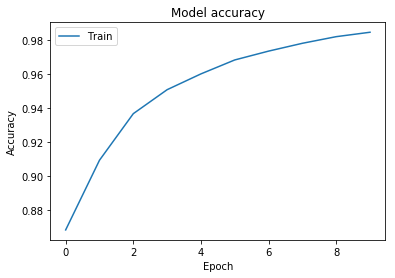

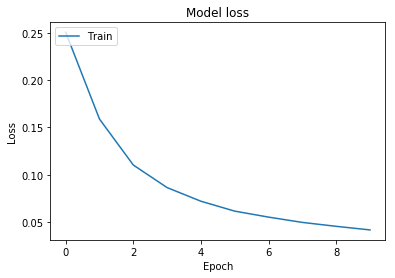

In [18]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [33]:
# CONFUSION MATRIX
y_test = y_train[:500]
X_test = X_train[:500]

y_pred = model.predict_generator(datagen.flow(X_test, batch_size=1), steps=len(X_test))

In [31]:
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred ]

conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    y_test_non_category = [ np.argmax(t) for t in y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y_pred ]

    conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [40]:
class_names = ['1', '2', '3', '4', '5', '6', '7']
plot_confusion_matrix(y_test, y_pred, classes=class_names, title='Confusion matrix, without normalization')
plt.show()

ValueError: Mix type of y not allowed, got types {'multilabel-indicator', 'continuous-multioutput'}

In [19]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

ISIC_0034839


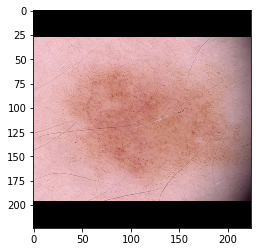

In [20]:
list_of_images = os.listdir(path_to_images)
filename = list_of_images[0]
print(filename[:-4])
input_size = 224

image = cv2.imread(path_to_images + filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
old_size = image.shape[:2]

ratio = float(input_size)/max(old_size)
new_size = tuple([int(x * ratio) for x in old_size])

image = cv2.resize(image, (new_size[1], new_size[0]))

delta_w = input_size - new_size[1]
delta_h = input_size - new_size[0]
top, bottom = delta_h//2, delta_h-(delta_h//2)
left, right = delta_w//2, delta_w-(delta_w//2)

color = [0, 0, 0]
new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                             cv2.BORDER_CONSTANT, value=color)

plt.imshow(new_img)


In [21]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2]
        
        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        image = cv2.resize(image, (new_size[1], new_size[0]))
        
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)
        
        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, 
                                     cv2.BORDER_CONSTANT, value=color)

#         arr = np.array(image)
        images_list.append(new_img)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [22]:
x, names = preprocess_images(path_to_images)

In [23]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    data_format="channels_last")

datagen.fit(x)

X Shape (1512, 224, 224, 3)
Name Shape (1512, 1)


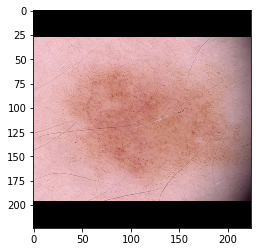

In [24]:
print("X Shape", x.shape)
plt.imshow(x[0])
print("Name Shape", names.shape)

In [52]:
model.load_weights(drive_base_path + 'models/VGG16_ISIC_cnn.h5')

In [25]:
predictions = model.predict_generator(datagen.flow(x, batch_size=1), steps=len(x))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [26]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [27]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)